In [25]:
# imports and settings
from pandas import DataFrame, melt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from ipywidgets import FloatSlider, interactive

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# plot settings
sns.set_theme()
plt.rcParams['figure.dpi'] = 100

1.  Introduce the idea of logistic regression in 1D and 2D.
2.  Introduce the sigmoid function and the logistic regression model.

# Using NN for Binary Classification

When we developed neural networks for regression problems the output layer of the network was linear (meaning it uses the "identity" actiavtion function).

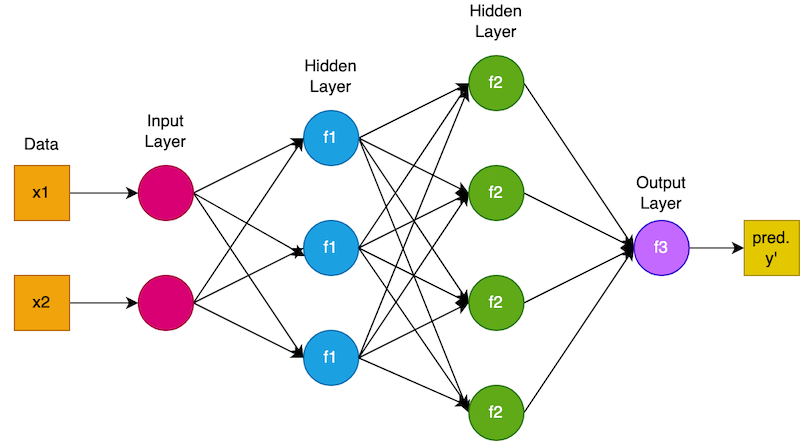

So for regression, the final activation function $f_3(x) = x$.  To convert this into a NN that can do binary classification between two classes labeled 0 and 1 we want the output layer to give us the probability that the inputs belong to the class labeled 1.  To do this we're going to let $f_3$ be a sigmoid function:

$$\sigma(x) = \frac{1}{1+e^{-x}}.$$

We can see from its graph that $$0 < \sigma(x) < 1$$

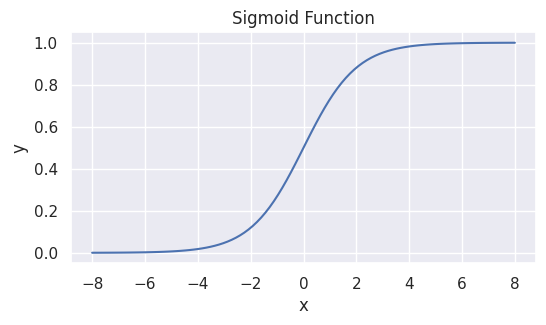

In [26]:
x = np.linspace(-8,8,101)
y = 1/(1+np.exp(-x))
df = DataFrame(dict(x = x, y = y))
fig, axis = plt.subplots(figsize=(6,3))
sns.lineplot( ax = axis, data = df , x = 'x', y = 'y')
axis.set_title('Sigmoid Function');

To predict the classification of each input given to the model we compare the final output of the NN to a threshold value which is typically 0.5.  If the output of the sigmoid layer is less than 0.5 we predict the input belongs to class 0, otherwise we predict class 1.

## Logistic Regression with a Single Input Variable

If we make our NN a have a single hidden layer with only one neuron then the model is called a logistic regression model:

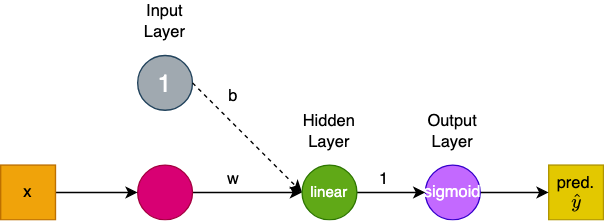

Mathematically our model is simply $$\widehat{y} = \sigma( w x + b).$$ How do we use it to classify points.  Given a sample of points on the real line that are labeled in two clases as 0 and 1, we want to predict the class for new points.

Say we have points on the real line like these:

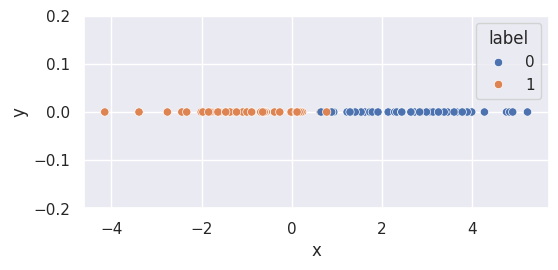

In [27]:
# create random data using make_blobs from scikit-learn
X,y = make_blobs(n_samples=100, n_features=1, centers=[[3],[-1]],
                 cluster_std=1.2, random_state = 42)
X = X.squeeze()
y = (y>.5).astype(int)

df = DataFrame({"x":X, "y":0*y, "label":y})
fig, axis = plt.subplots( figsize = (6,2.5))
sns.scatterplot(ax = axis, data=df, x="x", y="y", hue="label")
axis.set_ylim(ymin=-.2,ymax=.2)
plt.show()

To see how logistic regression works plot the label (0 or 1) vs x and play with the sliders in the plot below to try to fit our model
$$\widehat{y} = \sigma( w x + b)$$ to the data:

In [28]:
# @title
# it's not important to understand this code, focus on the idea of
# how the sigmoid curve is trying to fit the data

def log_reg1_plot(w = 1.0, b = 0.0):
  # assumes data is in global namespace as X,y

    num_pts = 201

    xmin, xmax = -5, 5

    dbx = -b/(w+0.001)

    x_ls = np.linspace(xmin,xmax,num_pts)
    z = w * x_ls + b
    sigma = 1/(1+np.exp(-z))
    hue_sigma = (sigma >= .5).astype(int)
    z_from_data = w * X + b
    sigma_from_data = 1/(1+np.exp(-z_from_data))
    pred = (sigma_from_data >= 0.5).astype(int)
    accuracy = 100*np.sum(pred==y)/len(y)
    title_str = f'Model: sigma({w:.1f}x + {b:.1f}), Accuracy = {accuracy:.1f}'

    df = DataFrame({"x":X, "y":y, "label":y})
    fig, axis = plt.subplots( figsize = (6,3))
    sns.scatterplot(ax = axis, data=df, x="x", y="y", hue="label")
    df2 = DataFrame({"x":x_ls, "y":sigma, "class":hue_sigma})
    sns.lineplot(ax = axis, data = df2, x="x", y="y",hue="class",legend=False)
    axis.set_ylim(ymin=-.05,ymax=1.05)
    axis.set_title(title_str)
    plt.plot( [dbx,dbx],[-.05,1.05],'k--')
    plt.show()

w_slider = FloatSlider(value = 1.0, min = -5.0, max = 5.0, step = .1, description = 'w')
b_slider = FloatSlider(value = 0.0, min = -5.0, max = 5.0, step = .1, description = 'b')

interactive(log_reg1_plot, w = w_slider, b = b_slider)

interactive(children=(FloatSlider(value=1.0, description='w', max=5.0, min=-5.0), FloatSlider(value=0.0, descr…

### Discussion:  
Why would accuracy not make a good loss function for optimizing the fit to the data?

## Logistic Regression with Two Input Variables

We can use logistic regression label points in plane as belonging to two classes.  

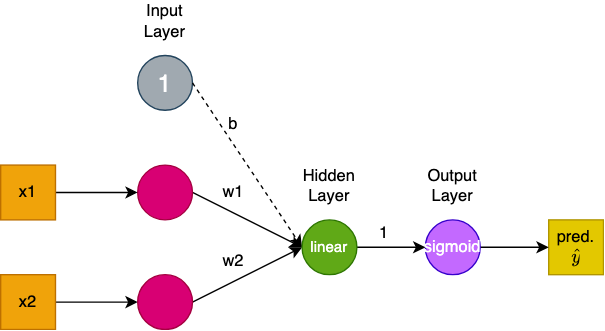

Mathematically, the model is now
$$\widehat{y} = \sigma( w_1 x_1 + w_2 x_2 + b ).$$

To see how it works, adjust the sliders for the interactive graph below:

In [29]:
# @title
# it's not important to understand this code, focus on the idea
# of fitting a sigmoid in 2 dimensions to maximize classification accuracy

# generate 2d classification dataset
ctrs = [[-2,2],[2,-2]]
std = 1.5
X, y = make_blobs(n_samples=400, centers=ctrs,
                  cluster_std = std, n_features=2,
                  random_state = 42)


def log_reg2_plot(w1 = 1.0, w2 = 1.0, b = 0.0):

    num_contours = 10
    num_pts = 20

    x1min, x1max = np.min(X[:,0]), np.max(X[:,0])
    x2min, x2max = np.min(X[:,1]), np.max(X[:,1])

    slope = -w1/(w2+0.001)
    intercept = -b/(w2+0.001)

    z_from_data = w1*X[:,0]+w2*X[:,1] + b
    sigma_from_data = 1/(1+np.exp(-z_from_data))
    pred = (sigma_from_data >= 0.5).astype(int)
    accuracy = 100*np.sum(pred==y)/len(y)
    title_str = f'Model: sigma({w1:.1f} x1 + {w2:.1f} x2 + b), Acc = {accuracy:.1f}%'

    fig,axis = plt.subplots(figsize = (5,5))
    # scatter plot, dots colored by class value
    df = DataFrame(dict(x1=X[:,0], x2=X[:,1], label=y))
    sns.scatterplot( ax = axis, x = 'x1', y = 'x2', data = df, hue = 'label')
    axis.set_xlim( xmin = x1min, xmax = x1max )
    axis.set_ylim( ymin = x2min, ymax = x2max)

    x1_ls = np.linspace(x1min,x1max,num_pts)
    x2_ls = np.linspace(x2min,x2max,num_pts)
    x1_mg, x2_mg = np.meshgrid( x1_ls, x2_ls )
    z = w1*x1_mg + w2*x2_mg + b
    sigma = 1/(1+np.exp(-z))

    axis.contourf(x1_mg, x2_mg, sigma, num_contours, alpha = 0.3, cmap = 'seismic')
    axis.plot([x])
    axis.set_title(title_str)
    plt.show()

w1_slider = FloatSlider(value = 1.0, min = -5.0, max = 5.0, step = .1, description = 'w1')
w2_slider = FloatSlider(value = 1.0, min = -5.0, max = 5.0, step = .1, description = 'w2')
b_slider = FloatSlider(value = 0.0, min = -5.0, max = 5.0, step = .1, description = 'b')

interactive(log_reg2_plot, w1 = w1_slider, w2 = w2_slider, b = b_slider)

interactive(children=(FloatSlider(value=1.0, description='w1', max=5.0, min=-5.0), FloatSlider(value=1.0, desc…

Manipulate the sliders to get as many blue(orange) points in the blue(red) region.  The decision boundary is in the middle of the light region.

Again, why wouldn't accuracy work well as a loss function?

We won't be able to fit more complex models manually so we need to determine an appropriate loss function.

## The Loss Function - Binary Cross Entropy

$$ BCE(y, \widehat{y} ) = -\frac{1}{n} \sum_{i=1}^n [ y_i \log(\widehat{y}_i) + (1-y_i) \log(1-\widehat{y}_i)]$$

To understand this loss function let's focus on a single data point $y$ and the predicted probability $\widehat{y}$.  The single term in the objective function would be
$$-y \log(\widehat{y}) - (1-y) \log(1-\widehat{y}).$$

Since the label $y_i$ is fixed, we want to adjust $\widehat{y}_i$ to minimize this term.  Since $y = 0$ or $y = 1$ one of the two parts of the term will be 0.  Let's plot this term for each of the two choices of label:

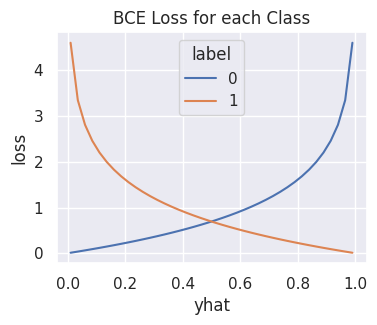

In [86]:
# @title
yhat = np.linspace(.01,.99,40)

# for label 0 the loss term becomes -log( 1 - yhat )
loss_0 = -np.log(1-yhat)

# for label 1 the loss term becomes -log( yhat )
loss_1 = -np.log(yhat)

data_wide = DataFrame({'yhat':yhat,'0':loss_0, '1':loss_1})
data_long = melt(data_preproc,['yhat'], var_name = 'label', value_name = 'loss')

fig,axis = plt.subplots( figsize = (4,3) )
sns.lineplot( ax = axis, data = data_long, x = 'yhat', y = 'loss', hue = 'label');
axis.set_title('BCE Loss for each Class');

Notice when the label is $y=0$, then the loss is minimized when $\widehat{y} = 0$.  Similarly, when $y = 1$, the loss is minimized when $\widehat{y} = 1.$ Thus, the loss function is minimized by making the probabilities $\widehat{y}_i$ match the labels $y_i.$

*Binary Cross Entropy is minimized by making the probabilities predicted by the model as close as possible to the actual labels.*

We'll use BCE loss for all of our binary classification models!

## Splitting Data in Training and Validation Sets

Before we see how to do Logistic Regression using PyTorch lets talk about an important step in building predictive models.  For the rest of this lesson we're going to focus on building a logistic regression model to predict two classes of points in 2D.  This will be our sample data.

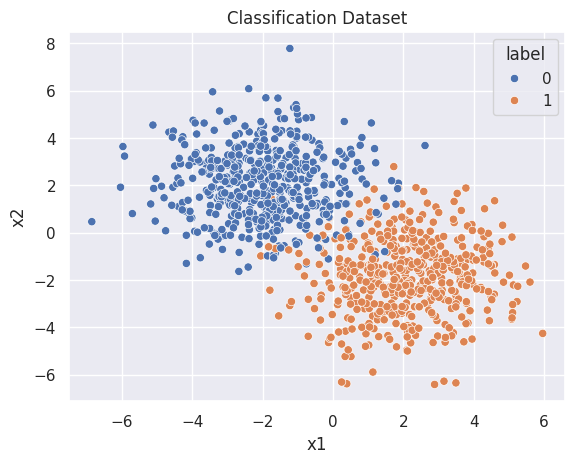

In [31]:
# generate 2d classification dataset
ctrs = [[-2,2],[2,-2]]
std = 1.5
X, y = make_blobs(n_samples=1000, centers=ctrs,
                  cluster_std = std, n_features=2,
                  random_state = 42)

# scatter plot, dots colored by class value
df = DataFrame(dict(x1=X[:,0], x2=X[:,1], label=y))
sns.scatterplot( x = 'x1', y = 'x2', data = df,
                hue = 'label').set(title='Classification Dataset');


We want our models to be able to make predictions on new input data that wasn't seen in training. Therefore we shouldn't assess the quality of the model on the training data.  Instead we'll split the dataset into a training set and a validation set.  The the training set is used to optimize the model parameters and the validation set is used to assess the quality of the model fit.  An 80%/20% split it commonly used, but it can also vary.

**Complex neural networks have so much flexibility that they can 'memorize' the training data and fail to make good predictions on unseen data.  This is called overfitting.**

The Scikit-Learn package `sklearn` has a helpful command called `train_test_split` that makes splitting a dataset simple.  In the code cell below we randomly select 80% of the data for training and 20% for the validation set.  

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                                                      random_state=42)

We can visualize the split data:

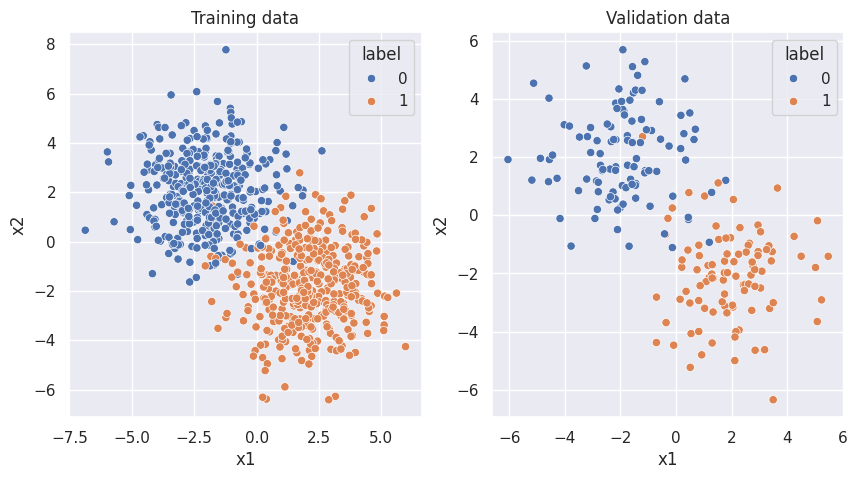

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

df_train = DataFrame(dict(x1=X_train[:,0], x2=X_train[:,1], label=y_train))
df_valid = DataFrame(dict(x1=X_valid[:,0], x2=X_valid[:,1], label=y_valid))

axes[0].set_title('Training data')
axes[1].set_title('Validation data')

sns.scatterplot( ax = axes[0], x = 'x1', y = 'x2', data = df_train, hue = 'label');
sns.scatterplot( ax = axes[1], x = 'x1', y = 'x2', data = df_valid, hue = 'label');

# Setting Up Logistic Regression with Pytorch

We need to do four things:

1.  Define our neural network using the nn.module class.
2.  Build a PyTorch Dataset and Dataloader for our X,y data generated by scikit-learn
3.  Build our training loop.
4.  Train our model and visualize the results.


## Step 1 - Define the PyTorch NN using nn.module

The NN we want to implement looks like this:

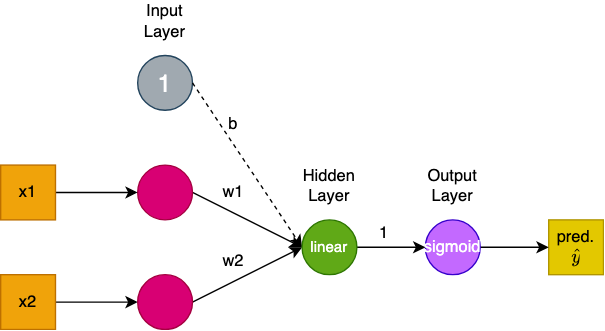

We can define it in a way that we can handle any number of inputs:

In [34]:
class LogisticRegression(nn.Module):
    '''
    Logistic Regression: 1 hidden layer with a single neuron
    and a sigmoid activation function
    '''
    def __init__(self, nInput):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(nInput, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return(self.layers(x))

## Step 2 - Datasets and Dataloaders

Our X,y data comes in the form of numpy arrays of double precision floats:

In [35]:
print(type(X))
print(X.dtype)

<class 'numpy.ndarray'>
float64


But we'll need the data to be PyTorch tensors of single precision floats.  We'll handle this change inside our Dataset class, but let's see how it works:

In [36]:
X_tmp = torch.tensor(X).float()
print(X_tmp.shape)
print(type(X_tmp))
print(X_tmp.dtype)

torch.Size([1000, 2])
<class 'torch.Tensor'>
torch.float32


Here we define our `RegressionData` class.

In [37]:
class RegressionData(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float().unsqueeze(-1)

    def __len__(self):
        return(len(self.X))

    def __getitem__(self, idx):
        return(self.X[idx], self.y[idx])

# instantiate Dataset object for current training data
dset_train = RegressionData(X_train, y_train)
dset_valid = RegressionData(X_valid, y_valid)

We will create the dataloaders just before the training loop further below, but we'll instantiate one here so we can see that it works correctly.

In [38]:
# instantiate DataLoader
train_dataloader = DataLoader(dset_train, batch_size=4 , shuffle=True)
inputs, targets = next(iter(train_dataloader))
print(inputs)
print(inputs.shape)
print(targets)
print(targets.shape)

tensor([[ 4.0887, -2.3751],
        [-0.0579, -4.4203],
        [ 4.4630, -0.4853],
        [ 3.9655,  0.0935]])
torch.Size([4, 2])
tensor([[1.],
        [1.],
        [1.],
        [1.]])
torch.Size([4, 1])


## Step 3 - Train the model



In [83]:
##################################################
## training the model
##################################################

epochs = 40
outputInterval = 4
learningRate = 0.1
batchSize = 100
nInput = 2

# Create a new instance of the model to randomize the weights each time
torch.manual_seed(40)
model = LogisticRegression(nInput)

# Make new instance of dataloader with batchSize
train_dataloader = DataLoader(dset_train, batch_size=batchSize, shuffle=True)
valid_dataloader = DataLoader(dset_valid, batch_size=batchSize, shuffle=False)

# Define the loss function and optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# Initialize lists to losses for later plotting
loss_train_list = []
loss_valid_list = []

# Run the training loop
for epoch in range(epochs):

    # Training Phase
    model.train()
    loss_train = 0.0
    correct_train = 0
    num_train = 0

    for inputs, targets in train_dataloader:

        # one training step
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        # accumulate accuracy and loss
        loss_train += loss.item()
        prediction = torch.round(outputs.detach())
        correct_train += (prediction == targets).sum().item()
        num_train += len(outputs)

    acc_train = 100 * correct_train / num_train
    loss_train = loss_train / num_train
    loss_train_list.append(loss_train)

    # Validation phase
    model.eval()
    loss_valid = 0.0
    correct_valid = 0
    num_valid = 0

    with torch.no_grad():
        for inputs, targets in valid_dataloader:
            outputs = model(inputs)
            loss = loss_function(outputs, targets)

            # accumulate accuracy and loss
            loss_valid += loss.item()
            prediction = torch.round(outputs)
            correct_valid += (prediction == targets).sum().item()
            num_valid += len(outputs)

    acc_valid = 100 * correct_valid / num_valid
    loss_valid = loss_valid / num_valid
    loss_valid_list.append(loss_valid)

    if (epoch + 1) % outputInterval == 0:
        print( (f'At epoch {epoch+1} '
                f'train_loss = {loss_train:.3e}, '
                f'val_loss = {loss_valid:.3e}, '
                f'acc_train = {acc_train:.2f}% '
                f'acc_valid = {acc_valid:.2f}%' ) )


At epoch 4 train_loss = 1.377e-03, val_loss = 1.391e-03, acc_train = 96.88% acc_valid = 94.50%
At epoch 8 train_loss = 1.026e-03, val_loss = 1.183e-03, acc_train = 97.12% acc_valid = 94.50%
At epoch 12 train_loss = 9.089e-04, val_loss = 1.130e-03, acc_train = 97.25% acc_valid = 95.00%
At epoch 16 train_loss = 8.468e-04, val_loss = 1.114e-03, acc_train = 97.25% acc_valid = 94.50%
At epoch 20 train_loss = 8.089e-04, val_loss = 1.111e-03, acc_train = 97.25% acc_valid = 94.50%
At epoch 24 train_loss = 7.834e-04, val_loss = 1.114e-03, acc_train = 97.25% acc_valid = 94.50%
At epoch 28 train_loss = 7.646e-04, val_loss = 1.119e-03, acc_train = 97.25% acc_valid = 94.50%
At epoch 32 train_loss = 7.505e-04, val_loss = 1.126e-03, acc_train = 97.12% acc_valid = 94.50%
At epoch 36 train_loss = 7.399e-04, val_loss = 1.133e-03, acc_train = 97.12% acc_valid = 94.50%
At epoch 40 train_loss = 7.312e-04, val_loss = 1.141e-03, acc_train = 97.12% acc_valid = 94.50%


It's a good idea to plot the training and validation loss to see if the training is effective and if there is overfitting (more about this soon).

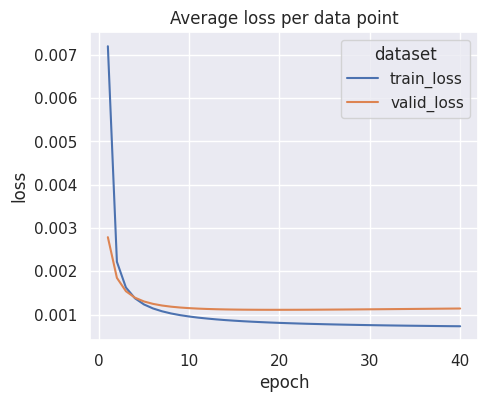

In [82]:
def plot_losses(train_loss, valid_loss):
  train_loss = np.array(train_loss)
  valid_loss = np.array(valid_loss)
  epoch = np.arange(1,len(train_loss)+1)
  data_wide = DataFrame({'epoch':epoch,'train_loss':train_loss,'valid_loss':valid_loss})
  data_long = melt(data_wide, ['epoch'], var_name = 'dataset', value_name = 'loss')
  fig,axis = plt.subplots( figsize = (5,4) )
  sns.lineplot( ax = axis, data = data_long, x = 'epoch', y = 'loss', hue = 'dataset')
  axis.set_title('Average loss per data point')

plot_losses(loss_train_list, loss_valid_list)

If for some reason you wanted to examine the parameters of the trained model, you could do it by looping over `model.parameters`.  The first two numbers are w1 and w2, followed by b.

In [41]:
for p in model.parameters():
    print(p.detach().numpy().round(4))

[[ 1.3004 -1.1684]]
[-0.1307]


## Step 4 - Visualize the results

The function `classify_2D_plot` below will help to visualize the results including the model and decision boundary.  It's only intended to work with a PyTorch model that takes two inputs and whose output is in [0,1].  Don't worry about the details of this function, but you can use it in your homework.

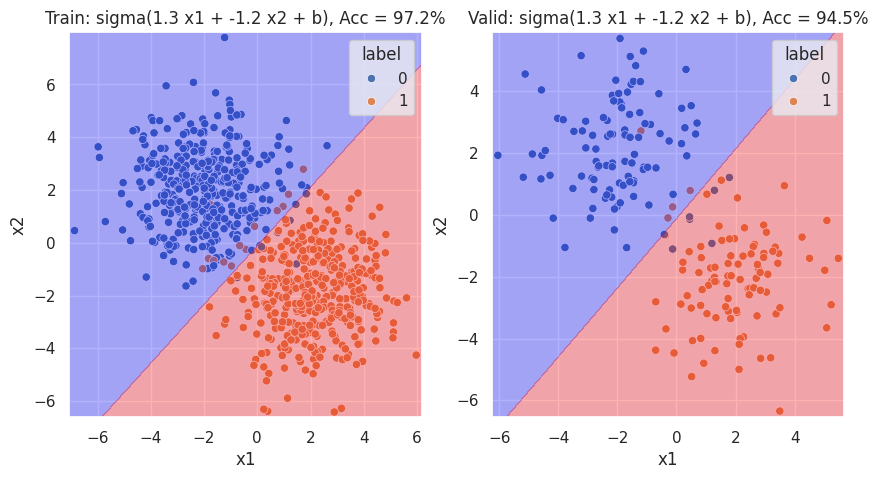

In [69]:
def classify_2D_plot(ax, pretitle_str, dataset, *model, num_contours = 1, npts = 10):

    x1 = dataset.X[:,0].squeeze().numpy()
    x2 = dataset.X[:,1].squeeze().numpy()

    pad_scale = 0.2
    x1min, x1max = np.min(x1), np.max(x1)
    x1pad = pad_scale*(x1max-x1min)
    x1min, x1max = x1min - pad_scale, x1max + pad_scale
    x2min, x2max = np.min(x2), np.max(x2)
    x2pad = pad_scale*(x2max-x2min)
    x2min, x2max = x2min - pad_scale, x2max + pad_scale
    labels_np = dataset.y.squeeze().numpy().astype(int)
    labels_torch = dataset.y.int()

    # scatter plot, dots colored by class value
    df = DataFrame(dict(x1=x1, x2=x2, label=labels_np))
    sns.scatterplot( ax = ax, x = 'x1', y = 'x2', data = df,
                  hue = 'label').set(title=pretitle_str);
    ax.set_xlim(x1min,x1max)
    ax.set_ylim(x2min,x2max)

    if len(model) > 0:
        model = model[0]
        # extract the parameters
        params = [ p.detach().numpy() for p in model.parameters()]
        w1 = params[0][0,0]
        w2 = params[0][0,1]
        b = params[1][0]
        slope = -w1/w2
        intercept = -b/w2

        # compute the accuracy on the data
        yhat = model(dataset.X)
        pred = (yhat >= 0.5).int()
        accuracy = 100*torch.sum(pred==labels_torch)/len(labels_torch)
        title_str = f'{pretitle_str}: sigma({w1:.1f} x1 + {w2:.1f} x2 + b), Acc = {accuracy:.1f}%'

        # plot the decision boundary and the fills
        x1_ls = torch.linspace(x1min,x1max,npts).float()
        x2_ls = torch.linspace(x2min,x2max,npts).float()
        x1_mg, x2_mg = torch.meshgrid( x1_ls, x2_ls )
        grid = torch.stack( (x1_mg.flatten(), x2_mg.flatten() ), dim = 1)
        with torch.no_grad():
            z = model(grid).reshape(npts,npts)
        ax.contourf(x1_mg.numpy(), x2_mg.numpy(), z.numpy(), 1, alpha = 0.3, cmap = 'seismic')
        ax.set_title(title_str)


fig, axes = plt.subplots(1, 2, figsize=(10,5))
classify_2D_plot(axes[0],'Train',dset_train,model,npts=20)
classify_2D_plot(axes[1],'Valid',dset_valid,model)